In [35]:
# inference-ad21.py: inference on the AD21 dataset from Li
import sys

sys.path.insert(0, "/home/liu00980/Documents/multimodal/tabular/tab-ddpm")


import numpy as np
import pandas as pd
import pickle
import subprocess
import os
import lib
from summarytools import dfSummary
import matplotlib.pyplot as plt
from dython.nominal import associations
import seaborn as sns

dataset_name = "ad21"
ddpm_dir = "/home/liu00980/Documents/multimodal/tabular/tab-ddpm"

FAKE_DATA_PATH = os.path.join(ddpm_dir, "exp", dataset_name, "ddpm_cb_best")
TRUE_DATA_PATH = os.path.join(ddpm_dir, "data", dataset_name)
DATA_INFO_PATH = os.path.join(TRUE_DATA_PATH, "info.json")

In [8]:
if not os.path.exists(os.path.join(FAKE_DATA_PATH, "y_train.npy")):
    subprocess.run(
        "python scripts/pipeline.py --config exp/house/ddpm_cb_best/config.toml --sample"
    )

info_dict = lib.load_json(DATA_INFO_PATH)

In [40]:
# all true data
truedf = pd.read_csv(os.path.join(ddpm_dir, "data", dataset_name, dataset_name + ".csv"))
dfSummary(pd.DataFrame(truedf))

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,APBB1[float64],Mean (sd) : 0.1 (0.2)min < med < max:-0.6 < 0.1 < 0.9IQR (CV) : 0.3 (0.6),462 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACXElEQVR4nO3bwYraQBzH8f/UVRKFBFnQmy9Q8ODRh+jD9hF68Am8evImikRMNzXG9LLQpXSXmk3wl8n3cx+cw5eYmcm4siwNUPHl0RMA3np69AR84ZwLzWxQcfilLMuXOufTVgRZA+dc+Pz8/C2KonGV8afT6eic+06UBFmXQRRF4+Vy+RLHcXbPwCRJgtVqNT4cDgMzI8hHT8AncRxnk8nkZ4WhYe2TaSkWNZBCkJBCkJBCkJBCkJBCkJBCkJBCkJDCxvgbnziPjm63W7/u+XQRQb76zHl0nudBURRfsyz7YWZVTmrwiiD/qHwevd1ux+v1eni9XntNTa4rCPIvVc6jj8cjZ9E1YVEDKQQJKQQJKd69Q7J1025eBcnWTft5FaSxddN6vgVpZmzdtBmLGkjx8gnZNkVR9M0scs5VGe7VnW6CfLA0Tft5ns9ns1mv1+vd9d5r5t+dboJ8sMvl8hQEwXCxWGTT6fR4z1gf73QTpIjRaMSdbmNRAzEECSkECSkECSkECSkECSkECSkECSkECSkECSmSR4dcQ+guuSC5htBtckEa1xA6TTFIM+MaQlexqIEUgoQUgoQUgoQUgoQU2VU2/o9vV2gJssV8vEJLkC3m4xVagvSAT1doWdRACkFCCkFCCkFCSmOLGj6y1ae4h9lIkHxkq091D7OpJyQf2YpT3cNsdB+Sj2z1Vd3DLIoisgb+7j8MkvdA/EuTf/fvBsl7IN7T5N/9R0/IQRRF4/l8bmEY/rrnR/f7fbDZbIZJkox2u93lnrHn8zkwM0vTNNjtdkPG6o5twm8WC5n2ClWVzQAAAABJRU5ErkJggg=="">",0(0.0%)
2,APOE[float64],Mean (sd) : 0.1 (0.2)min < med < max:-0.4 < 0.1 < 0.7IQR (CV) : 0.3 (0.5),462 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACc0lEQVR4nO3bP27iQBSA8TdLQANItvgj6LhApC2QaDjAlnvYPcIWFFtzAzokhIzwxsIYp0iihJU2aGwcP9vfrx/h4pONPW9MmqYCaPGt7AsAPnoo+wI0McZ0RaSTcfkpTdOne15PExHkK2NMdzQa/fQ8b5Bl/eFw2BtjfhFlPgT5ruN53mC5XD75vh+5LAyCwK5Wq8Fut+uICEHmQJD/8H0/mkwmfzMs7d79YhqIlxqoQpBQhSChCkFCFYKEKgQJVQgSqhAkVCFIqMJOzZ0kSdIWEc8Yk2U5gxmvCPIOwjBsx3H8fTabtVqtltM+uAiDGR/VLsgcI2Te5XJpZ/nN0+n0YK3tzefzaDqd7l3WMphxTWWQOaKyw+Hwh+/7fdeFcRzbJEkeoyj6LSJZhiuk3+8zmJGTuiDzzCXGcWxF5HGxWPwZj8cHl7WbzWawXq975/O55fq7uB91QUqOucS3qKy1seudar/fc5dSQGOQIpJtLpGoqo/vkFCFIKEKQUIVgoQqBAlVCBKqECRUIUioQpBQhSChSmFbh2WMgaH6Cgky78RO3jEwVFdRd8jcEzuMgTVTodM+TOzAFS81UIUgoYraAd0m4QjtO4IsGUdorxFkyThCe40gleAI7QteaqAKQUIVgoQqBAlVCBKqECRUIUiownfIiqvbtiNBVlgdtx0JssLquO1IkDWQddsxSRJPlD3uCbKhtD7uCbKhtD7uPw2So6z1p23K6L9BcpQVZfjsDslRVny5m/8hOcqKr8RLDTIpaoeIIOGsyE9GBAlnRX4yIkhkVsQno5tBBkFgXX/teDxaEZEwDO12u+2xlrVvbvX0DK6Bro0Uu6w2AAAAAElFTkSuQmCC"">",0(0.0%)
3,APP[float64],Mean (sd) : -0.1 (0.3)min < med < max:-1.4 < -0.1 < 0.8IQR (CV) : 0.4 (-0.2),462 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACY0lEQVR4nO3czYraUBiH8ffUUeIHCX6gO29goAvBjRfQZS+2l9CFi1l7B+4EkYjpBGNMN9IOhQ7EGPwneX5bOZjFg5wcX47LsswAFV+e/QDARy/PfgCYOee6Zta5c/k5y7L3Rz7PMxHkgxSIyhuNRt+CIOjf873H4/HgnPtRlygJ8gGcc93xePzd9/1h3rVJknhm9rpcLt8mk8kxz9owDL31ej3c7/cdMyNI/NHxfX+4Wq3egyCI8yzcbrfDzWbT8zwvmU6nv+747u4da2QR5AMFQRDnjepwONQqqKJ4y4YUgoQUgoQUgoQUgoQUgoQUgoQUgoQUgoQUgoQUgoQUgoQUgoQUpn0qLk3Ttpn5zrl7lstNmxNkhUVR1E6S5Ot8Pm+1Wq1cc5hmmtPmBFlh5/P5xfO83mKxiGez2SHPWtVpc4KsgX6/n3sw+EZuOJiXGkghSEghSEghSEghSEghSEghSEghSEghSEghSEjhr8MPClyp51+v1/ajn6eJCPKm6JV6aZq+xnH808zu+U8ZNwT5V+Er9S6XS6ush2sKgvwHV+o9Fy81kEKQkEKQkEKQkEKQkEKQkEKQkMI5ZIMpXjJAkA2leskAQTaU6iUDBNlwapcM1C5IRsiqrVZBMkJWfbUK0hghq7y6BWlmjJBVGQfjkEKQkEKQkCK5h+ToprnkguToptnkgjSObiqhrMEMxSDNjKMbZWUOZpQWJPvA+ipzMKOUINkHNkMZgxmfBlnkV24wGExXq9WRfSDy+G+Qj/iVS5Lkzcxy7zHMzKIo8na7XS/PmtPp5LFWe20Yht5nn/8G7WFz0xYNzFIAAAAASUVORK5CYII="">",0(0.0%)
4,ATP5F1[float64],Mean (sd) : -0.0 (0.3)min < med < max:-0.8 < -0.0 < 0.9IQR (CV) : 0.4 (-0.0),462 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACjElEQVR4nO3bu47aQBSA4TPhEgOKDSKCzi1FJApKmrxBHjZtuhTQI1oqGoRAYISDg/GSIivtEmlJfCEc7P/rR+v

In [9]:
# true test data
X_num_test = np.load(os.path.join(TRUE_DATA_PATH, "X_num_test.npy"))  # original scale
y_test = np.load(os.path.join(TRUE_DATA_PATH, "y_test.npy"))

column_names = [info_dict["y_name"]] + info_dict["X_names"]
truedf = pd.DataFrame(
    np.concatenate([y_test[:, None], X_num_test], axis=1),
    columns=column_names,
)
new_types = {column_name: 'float' for column_name in column_names}

truedf = truedf.astype(new_types)

# original scale
dfSummary(pd.DataFrame(truedf))

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,APBB1[float64],Mean (sd) : 0.2 (0.3)min < med < max:-0.4 < 0.2 < 0.8IQR (CV) : 0.4 (0.7),47 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACo0lEQVR4nO3cvY7aQBRA4TuwIPMjWwgFOpqUkVK45CHysHmEFDwBRZpUdEgIGeGshTFOkSBtAbswY4e55nz9sFMcwXrGM6YsSwF813r0BIBbvDx6Ar4yxvREpGs5/FCW5WuV83l2hHqBMaY3Ho+/hWE4shm/2+22xpjvxFodQr2sG4bhaD6fv0ZRlN0zMEmSYLFYjDabTVdECLUihPqOKIqyyWTy22Jor/LJPDkepqACoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSpwCrUGRVF0RCQ0xtgM5/KKCwi1YmmadvI8/zqbzdrtdvuuOwFEuLziGkKt2OFweAmCoB/HcTadTrf3jOXyiusItSaDwYDLKyrEwxRUIFSo4PVPP1c/4szbULn6EW95G6pw9SPe8DlUEeHqR/zFwxRUIFSo4P1Pvy3H/fbwdDp1Kp7STRznLdLQ1Y5Ghuq6357neVAUxZcsy36IiM3/x1Zc5y3S3NWORobqst8uIrJarUbL5bJ/PB7bdczvGtd5N3m1o5Ghntnut2+324euGDi8JyDS0NUOHqagAqFCBUKFCoQKFQgVKhAqVCBUqECoUOHDBX/Ht+xbInKyHPuw/XbYqfNExruhurxlXxRFJ03Tz8Ph8Fer1crvHf+o/XbYqftExkffqNZv2f/bL/8Ux/FPTfvtsFbriYyb9vpt3rI/75dr3W+HnbpOZPAwBRUIFSo0+jW/Z+R4QsDbVRpCbRCXEwK+r9IQaoO4nBDwfZWGUBvIZqXF91UaHqagAqFCBUKFCoQKFQgVKhAqVCBUqECoUOGmBf8kSYJ7P3i/3wciImmaBuv1uv8/x2v921rn7Tr+lr7+AHMOoMm6oOjCAAAAAElFTkSuQmCC"">",0(0.0%)
2,APOE[float64],Mean (sd) : 0.1 (0.2)min < med < max:-0.4 < 0.2 < 0.6IQR (CV) : 0.3 (0.5),47 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACtElEQVR4nO3dMW/aQBiH8fcgRA4gI4SabFk6VurAmA/RD9uP0CGfIEOXTmxICBHFDcIYOrSR0qXB9/qC/+7z2w8f4pGju5Ny4Xg8GtB2vXNPADjFxbkn0EUhhCszu4wcvjsej89NzqcLCLVhIYSr2Wz2Jc/zacz4x8fHdQjhK7H+jVCbd5nn+fTu7u55Mpls6wzcbDbZ/f39dLVaXZoZob5CqIlMJpPt9fX1z4ihV41PpgNYTEECoUICoUICoUICoUICoUJCq7enOOHBi9aGygkPXmttqMYJD15pc6hmxgkPfmMxBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmt/9fo/5uqqgZmlocQYj+ik7fBEGqLFEUxKMvy8+3tbb/f79e6YONFV2+DIdQW2e12F1mWDefz+fbm5mZdd3yXb4Mh1BYajUaxN8GYdfQ2GBZTkJD0jeq8IjI/HA6D2Gc3sCjpmdkhYpxr3l7O7+1aiKW8EjRZqN4rIsuyzKqq+rTdbr+ZWa0/g95FSVVVg6IoPo7H4x+9Xq+sM9Yzby/v9/YsxFJfCZryjRp9RaSZ2WKxmD48PAz3+32/7ljvouTPsz/M5/Pvdcd75u3l+d4NLMSSXgmafDEVe0Xker12LwpiFyUvz44Z38S8vRyLMffcU10JymIKEggVEggVEggVEggVEt5c9Ts2cc+68Y36nIcFSX/vf4bq2cQ958Y36vMeFqT+vd96o0Zv4p5z4xv1NXRIkuz3PmnDP2YTtw0b36jPe0iSCospSDjpjbrZbLK6H/z09JSZmRVFkS2Xy+F7jld9tuq8veNP6esX4QipyhG1jwsAAAAASUVORK5CYII="">",0(0.0%)
3,APP[float64],Mean (sd) : -0.1 (0.3)min < med < max:-0.8 < -0.1 < 0.6IQR (CV) : 0.5 (-0.2),47 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACeklEQVR4nO3dQY6iQBiG4b/G1qAmEGOiOy8wySxceog57BxhFp7AG7gzMUaj00REZjU77ZaCGvjo99lXUyFvsIsK4IqiMKDtvjU9AeAVb01PoK2cc0MzG3gOvxZF8V7nfL46Qn3AOTecTqc/4zie+Iw/nU4H59wvYq0PoT42iON4slqt3pMkScsMPB6P0Xq9nuz3+4GZEWpNCPUDSZKks9nsj8fQYe2T+eJYTEECoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICoUICr50MIM/zvpnFzjmf4byt+gFCrdnlculnWfZjsVj0er1eqZcAm/G26mcItWbX6/UtiqLRcrlM5/P5ocxY3lb9HKEGMh6PeVt1jVhMQUKrr6h8Qqe8rp6z1obKJ3TK6/I5a22oxid0fHT2nLU5VDPjEzo+unjOWExBAqFCQut/+n1V3MaM7/d7v+YpvaTJeVc8tlnAuwadDLXqNmaWZVGe59/TNP1tZj7/63lpct5Vj20W9q5BJ0Otso1pZrbdbiebzWZ0u916Ieb3TJPzrnrs0HcNOhnqP77bmIfDodHVb5PzrrD1axbwrgGLKUj49Ira1S05aPkw1C5vyUHLZ1fUzm7JQctLi6kubslBC4spSCBUSAh6H1V1GxN+Qj59GyxU1W1M+An99G2wUFW3MeEn9NO3wbdQVbcx4SfU07cspiCBUCGBUCGBUCGBUCGBUCGBUCHhpfuox+MxKvuHz+dzZGZ2uVyi3W43+p/jVY+tOu+q41/p6y83LcaZuv5XOwAAAABJRU5ErkJggg=="">",0(0.0%)
4,ATP5F1[float64],Mean (sd) : -0.0 (0.3)min < med < max:-0.6 < 0.0 < 0.4IQR (CV) : 0.4 (-0.1),47 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAA

In [41]:
# fake test data
X_num_test_syn = np.load(os.path.join(FAKE_DATA_PATH, "X_num_train.npy"))  # original scale
y_test_syn = np.load(os.path.join(FAKE_DATA_PATH, "y_train.npy"))


fakedf = pd.DataFrame(
    np.concatenate([y_test_syn[:, None], X_num_test_syn], axis=1),
    columns=column_names,
)
new_types = {column_name: 'float' for column_name in column_names}

fakedf = fakedf.astype(new_types)

# original scale
dfSummary(pd.DataFrame(fakedf))


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,APBB1[float64],Mean (sd) : 0.1 (0.4)min < med < max:-0.6 < 0.1 < 0.9IQR (CV) : 0.4 (0.3),429 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACaUlEQVR4nO3cQW7iMBSA4eehoABSIkQFOy4wUhcsOcQcdo4wSJyAG7BDilAQmUaEkG46mmqkaYkTw4vzf3tTL34qY9k2ZVkKoMW3R08A+Ojp0RPwhTFmKCIDy+Hnsixfm5xPWxFkA4wxw+l0+iMMw4nN+OPxeDDG/CRKgmzKIAzDyWq1eo2iKKsyMEmSYLPZTOI4HogIQT56Aj6JoiibzWa/LYYOG59MS/GjBqoQJFQhSKhCkFCFIKEKQUIVgoQqBAlVCBKqECRUIUioQpBQhSChCqd9PqhxyDa8Xq/9pufTRQT5rs4h2zzPg6IovmdZ9ktEbI6f4R1B/mV9yHa320222+3ocrn0XE2uKwjyHzaHbA+HAwdsG+JdkKwD282rIFkHtp9XQQrrwNbzLUgRYR3YZmyMQxWChCoECVUIEqoQJFQhSKji5bZP2xRF0ReR0BhjM9yrp/w+DZI3D91L07Sf5/nLYrHo9Xq9Spv5Iv495fffIHnz8D7O5/NTEASj5XKZzefzQ5WxPj7l99l/SN48vKPxeMxTfnLDGpI3D3FP/MqGKgQJVQgSqhAkVCFIqEKQUIUgoQpBQhUOV8CKq3MOBInKXJ5zIEjYcHbOQWWQvD7RDi7OOagLktcnuk1dkMLrE52mMUgR4fWJrmIfEqoQJFQhSKjibA1Z42onWzcd5iTIOlc72bqpxrc73U6CrHO1k62b2/l4p9vpto/N1U62bm5X9073er2exXH8bIw5VvzTzpZVavchcTubL77WZRVBdpTWZRVBdpy2ZdWXQSZJElT90NPpFIiIpGka7Pf7EWMZ+8dXPb0Bcq+vzyBwHw8AAAAASUVORK5CYII="">",0(0.0%)
2,APOE[float64],Mean (sd) : 0.1 (0.3)min < med < max:-0.4 < 0.1 < 0.7IQR (CV) : 0.3 (0.3),424 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACaklEQVR4nO3dQY6aUBzH8f+ro0FNIMZEd16gSRcuPUQP2yN04Qm8gTsTQzDSISLSRW1mbNIxgIw/4PvZvwmL7/h8D3i6PM8NUPHl2RcAvPfy7AtQ4pwbmtmg5PBTnuevj7yeLiLIK+fccDqdfvd9f1Jm/OFwCJ1zP4iyGoJ8M/B9f7JarV6DIEiKDIyiyFuv15P9fj8wM4KsoHVBVph2/cvl0g+CIJzNZr9KjB+WGIN/tCrIKtNumqZelmVfkyT5aWZlgsQDtCpIqzDtbrfbyWazGZ3P515dF4f72hakmZkFQZAUnXbDMGTKFcA+JKQQJKQQJKQQJKRILmqq7iU++nrweeSCbOpeYpZlfTPznXNlhnMf/EouSGvgXmIcx/00Tb8tFoter9crdM1m3Ad/TzFIM2vWXuLpdHrxPG+0XC6T+XweFhnLffBbHwbJ41jFjMfjwv9EV2zKX/03SB7HwjN89AnJ41j4dHe/Q5b5LnfFNITC2BiHFIKElNq2fSpsFHO3pcNqCbLKRjFPbndbLUFW2Sjmye1uq/VOTZmNYp7c7jYWNZBCkJBCkJBCkJBCkJBCkJBCkJBCkJBCkJBCkJBCkJAi+9YhtNX1AiBBorA6XwAkSJRR2wuABInS6ngBkEUNpBAkpDBlC+DktDcE+WScnHaLIJ+Mk9NuEaQITk77g0UNpBAkpBAkpBAkpLCo6TDFn18hyI5S/fkVguwuyZ9fIciOU/v5FRY1kMInZMO17aRigmywNp5UTJAN1saTigmyBdp0UjGLGkghSEi5O2VHUeQV/aPH49EzM4vj2NvtdiPGMvavez39BtWNstxLzRvYAAAAAElFTkSuQmCC"">",0(0.0%)
3,APP[float64],Mean (sd) : -0.1 (0.5)min < med < max:-1.4 < -0.1 < 0.8IQR (CV) : 0.5 (-0.2),425 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACa0lEQVR4nO3cQYriQBSA4VdjK1EhQRx05wUGZuHSQ8xh5wgjeAJv4E4IIWKmgzFmNgPTDHRrKinrJf1/+2pD+NtOOpVnqqoSQIsvvg8AeOvF9wFAxBgzFpGR5fJLVVWvbR6PTwTpmTFmPJ/Pf4RhOLNZfzqdEmPMz75ESZD+jcIwnG02m9coivI6C9M0DXa73SyO45GIECTaE0VRvlgsflssHbd+MB5xUwNVCBKqECRUIUioQpBQhSChCkFCFYKEKgQJVQgSqhAkVOFZdksabCELb7fbsO3j6SqCbEGTLWRFUQRlWX7L8/yXiNhsrugVgmyH9Rayw+Ew2+/3k+v1OnB1cF1CkC2y2UKWJEmvto81xU0NVCFIqMKf7I4ry3IoIqExxma5uhfECLLDsiwbFkXxfbVaDQaDQa2bKRGdL4gRZIddLpeXIAgm6/U6Xy6XSZ21Wl8QI8gemE6nvXlBjJsaqMI35Bs8/vOPIP/i8Z8OBPkPj/8UIMj/8PjPL25qoApBQhWChCoECVUIEqpwlw0rrsZQEyRqczmG+sMgGcaOdzgbQ/1ukAxjxz0uxlB/9A3JMHY83d1rSIax45n4tw9UIUioQpBQhSChCkFCFYKEKgQJVQgSqhAkVCFIqEKQUIUgoQpBQpXe7RhnPs/jGgw7dXauehUk83ke12TYqctz5SxIT6OGmc/zoCbDTl2eKydB+h41zHyex9kMO3V5rpwE2XTU8Ha7XcRx/NUYc6r50Z/uOrBvnF5D2vz2ab22wXOou6nRem2D57gbZJqmQd0fej6fAxGRLMuC4/E4sVnbRJPPZa3btfd6+gOjpKIRx2TYfgAAAABJRU5ErkJggg=="">",0(0.0%)
4,ATP5F1[float64],Mean (sd) : -0.0 (0.4)min < med < max:-0.8 < -0.0 < 0.9IQR (CV) : 0.4 (-0.0),414 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACXUlEQVR4nO3cT4riQBiH4a/GVqJCggi68wIDs3DpIeawc4RZeAJv4E6QEDHTwRgzm4bpGZi

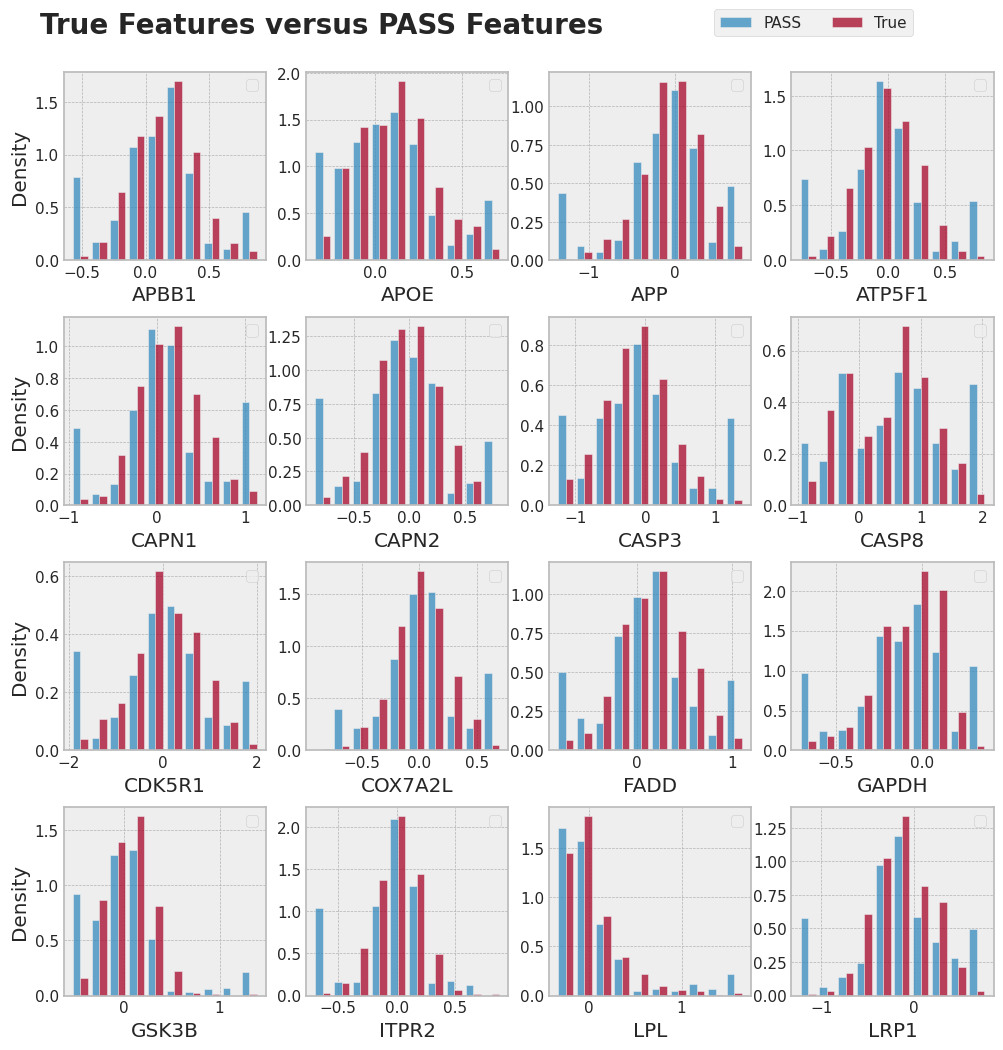

In [45]:
plt.style.use("bmh")

alpha = 0.75
nrows, ncols = 4, 4


fig, axs = plt.subplots(nrows, ncols, figsize=(3 * nrows, 3 * ncols))
for i, column_name in enumerate(column_names[: nrows * ncols]):
    row, col = i // ncols, i % ncols
    axs[row, col].hist(
        [fakedf[column_name], truedf[column_name]],
        label=["PASS", "True"],
        density=True,
        alpha=alpha,
    )
    axs[row, col].set_xlabel(column_name)
    if col == 0:
        axs[row, col].set_ylabel("Density")
    axs[row, col].legend("")

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, bbox_to_anchor=[0.75, 0.903])


plt.suptitle("True Features versus PASS Features", weight="bold", fontsize=20, x=0.34, y=0.93)

# set the spacing between subplots
plt.subplots_adjust(
    wspace = 0.2,
    hspace = 0.3,   # the amount of height reserved for white space between subplots
)

plt.show()

/tmp/ipykernel_17769/3623452708.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 3, 1)


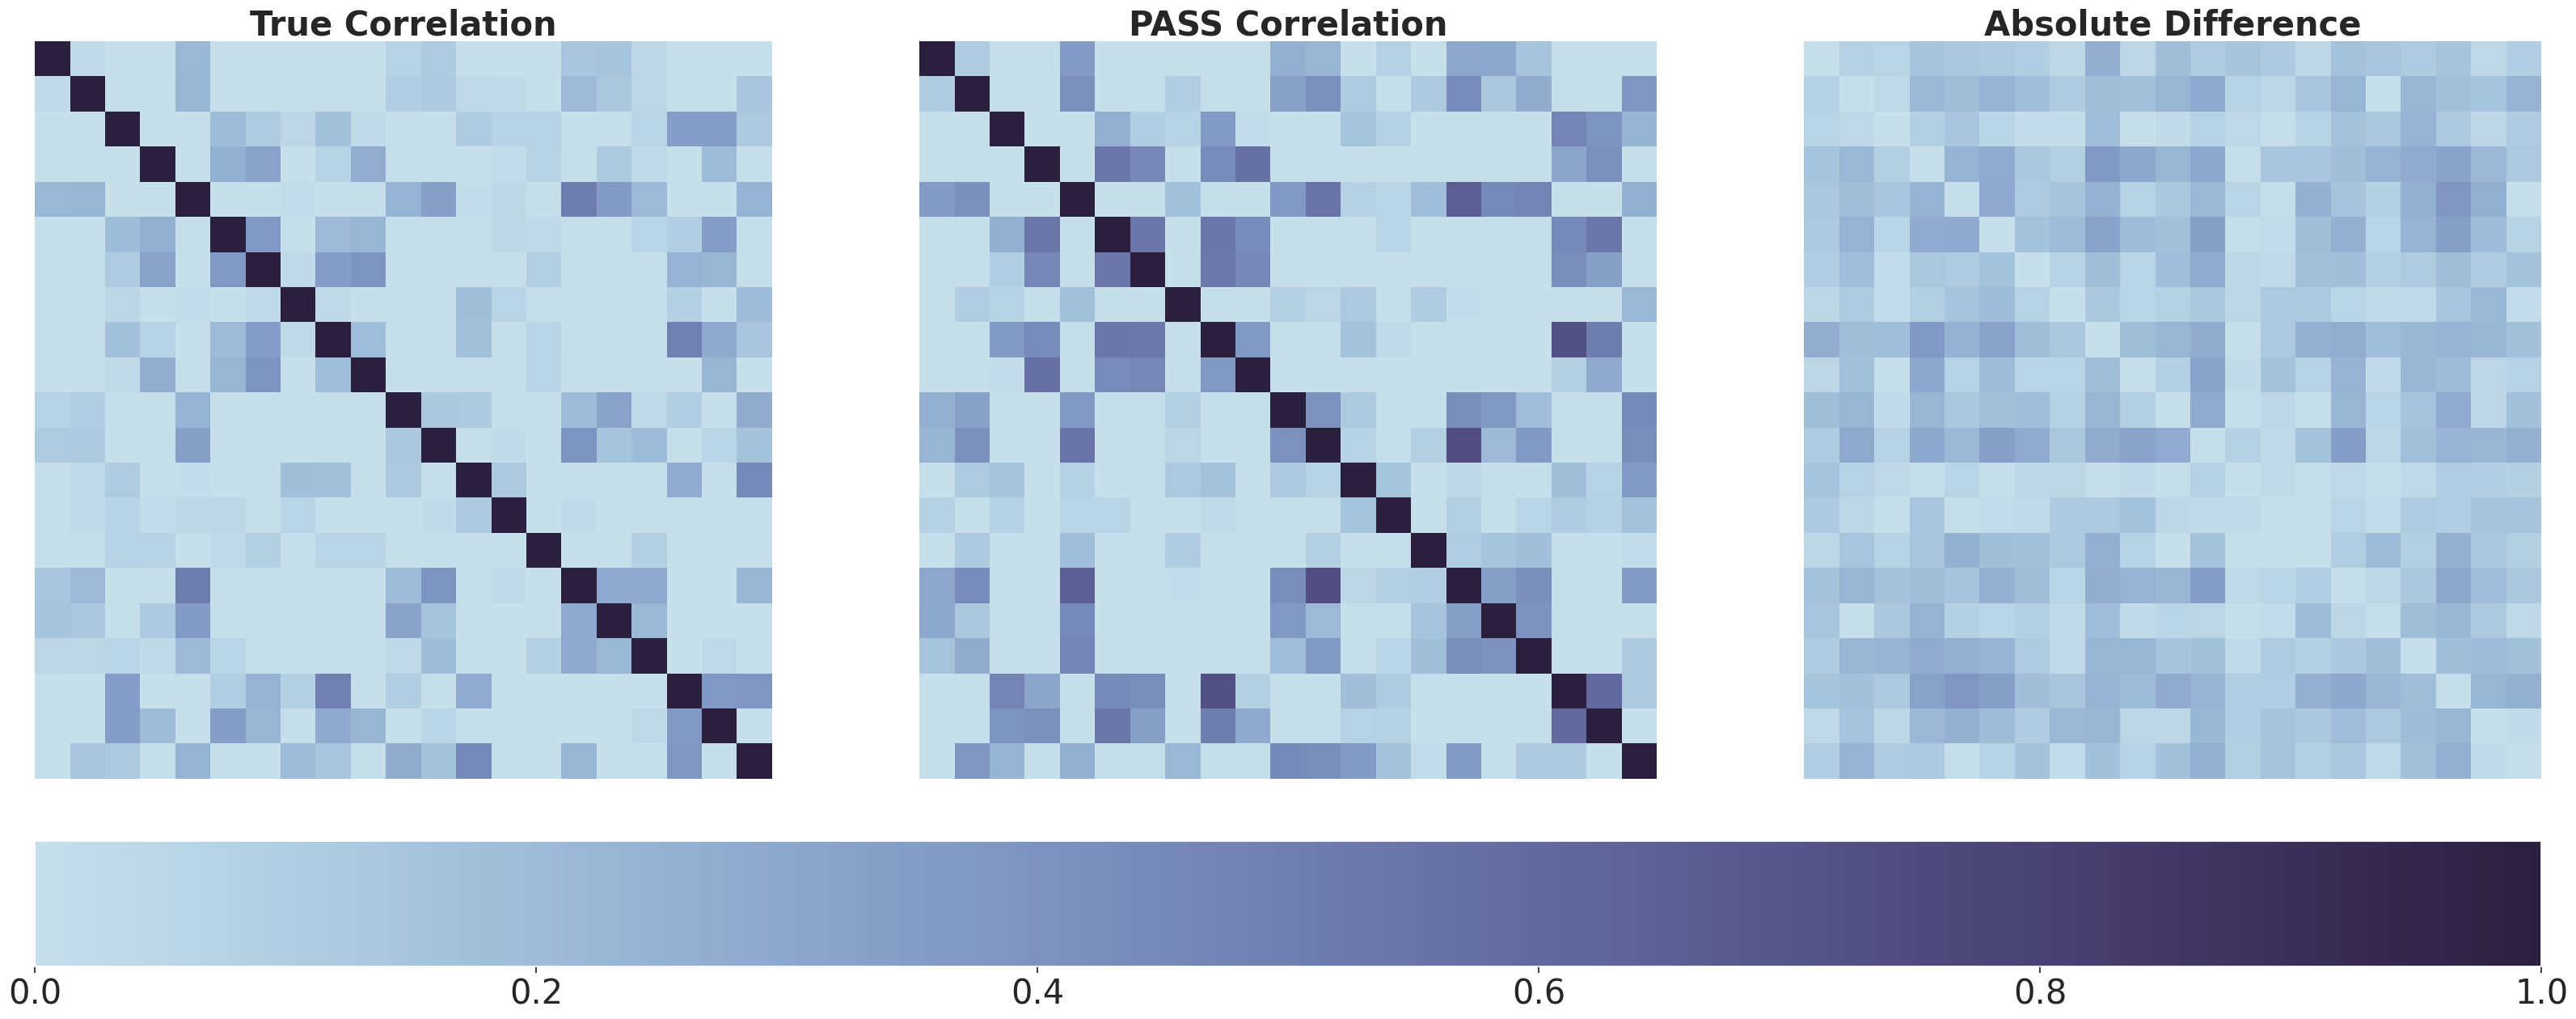

In [46]:
temp_truedf = truedf.copy()
temp_fakedf = fakedf.copy()


true_corr = associations(temp_truedf, nom_nom_assoc='theil', annot=False, cmap='Blues', plot=False)['corr']
fake_corr = associations(temp_fakedf, nom_nom_assoc='theil', annot=False, cmap='Blues', plot=False)['corr']
diff_corr = np.abs(true_corr - fake_corr)
# heatmaps
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True, n_colors=100)


kwargs = {
    'cmap': cmap,
    'annot': False,
    'xticklabels': False,
    'yticklabels': False,
    'cbar': False,
    'square': True,
    'vmin': 0,
    'vmax': 1
}

plt.subplots(figsize=(40, 20))


ax1 = plt.subplot(1, 3, 1)
img = sns.heatmap(true_corr, **kwargs, ax=ax1)
ax1.set_title('True Correlation', weight='bold', fontsize=30)


ax2 = plt.subplot(1, 3, 2)
sns.heatmap(fake_corr, **kwargs, ax=ax2)
ax2.set_title('PASS Correlation', weight='bold', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
sns.heatmap(diff_corr, **kwargs, ax=ax3)
ax3.set_title('Absolute Difference', weight='bold', fontsize=30)

mappable = img.get_children()[0]
cbar = plt.colorbar(mappable, ax = [ax1, ax2, ax3], orientation = 'horizontal', pad=0.05)
cbar.ax.tick_params(labelsize=30)

plt.show()